In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

## 悬崖行走问题
想象一个机器人在悬崖边行走。最短路径是沿着悬崖边缘，但如果掉下悬崖将获得巨大惩罚。由于使用ε-greedy策略（有小概率随机行动），沿悬崖边行走是危险的。

## SARSA 和 Q-learning 的比较
SARSA 和 Q-learning 是两种常用的强化学习算法。SARSA 是一种在线学习算法，它使用当前策略来选择动作，并使用当前策略来更新 Q 值。Q-learning 是一种离线学习算法，它使用目标策略来选择动作，并使用目标策略来更新 Q 值。

运行上述代码，你会观察到：

### 安全性与最优性权衡:

- SARSA学习出的路径较为保守，会远离悬崖边缘
- Q-learning学习出的路径更冒险，会沿悬崖边缘（理论上最短路径）


### 累积奖励差异:

- 训练初期，Q-learning可能获得更差的累积奖励（因为更频繁地掉下悬崖）
- 长期来看，SARSA因选择更安全路径，整体性能更稳定
- Q-learning在纯贪婪策略（不探索）下表现最佳，但训练中的表现可能波动较大


### 更新方式的本质差异:

- SARSA在更新时考虑了真实采取的下一个动作
- Q-learning在更新时只考虑理论上最优的下一个动作


SARSA是"悲观"的，它将探索的风险也考虑在内；而Q-learning是"乐观"的，它假设未来都会选择最优动作，忽略了探索带来的风险。


## 其他可以显示两种算法差异的场景

1. 具有随机性的环境：任何具有随机转移或奖励的环境，两种算法都会有差异
2. 陷阱环境：类似悬崖行走，任何有高风险高回报选择的环境
3. 重大惩罚环境：当错误决策带来非常大的负面奖励时

你可以修改上述代码中的环境设置，调整悬崖的惩罚值或探索率(epsilon)的大小，观察两种算法性能差异的变化。

In [21]:
class CliffWalkingEnv:
    def __init__(self):
        self.width = 12
        self.height = 4
        self.start_state = (3, 0)
        self.goal_state = (3, 11)
        self.cliff = [(3, i) for i in range(1, 11)]  # 悬崖位置
        self.current_state = self.start_state
        
    def reset(self):
        self.current_state = self.start_state
        return self.current_state
    
    def step(self, action):
        # 动作: 0=上, 1=右, 2=下, 3=左
        i, j = self.current_state
        if action == 0:  # 上
            i = max(i - 1, 0)
        elif action == 1:  # 右
            j = min(j + 1, self.width - 1)
        elif action == 2:  # 下
            i = min(i + 1, self.height - 1)
        elif action == 3:  # 左
            j = max(j - 1, 0)
        
        self.current_state = (i, j)
        
        # 处理悬崖和目标状态
        if self.current_state in self.cliff:
            reward = -100
            self.current_state = self.start_state  # 掉下悬崖回到起点
            done = False
        elif self.current_state == self.goal_state:
            reward = 0
            done = True
        else:
            reward = -1  # 每一步的惩罚
            done = False
            
        return self.current_state, reward, done

def epsilon_greedy_policy(Q, state, epsilon):
    if np.random.random() < epsilon:
        return np.random.choice(4)  # 随机选择动作
    else:
        return np.argmax(Q[state])

def sarsa(env, num_episodes=500, alpha=0.1, gamma=0.95, epsilon=0.1):
    # 初始化Q表
    Q = np.zeros((env.height, env.width, 4))
    rewards_per_episode = []
    
    for episode in range(num_episodes):
        state = env.reset()
        action = epsilon_greedy_policy(Q, state, epsilon)
        total_reward = 0
        done = False
        
        while not done:
            next_state, reward, done = env.step(action)
            next_action = epsilon_greedy_policy(Q, next_state, epsilon)
            
            # SARSA更新 - 使用实际采取的下一个动作
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])
            
            state = next_state
            action = next_action
            total_reward += reward
            
        rewards_per_episode.append(total_reward)
        
    return Q, rewards_per_episode

def q_learning(env, num_episodes=500, alpha=0.1, gamma=0.95, epsilon=0.1):
    # 初始化Q表
    Q = np.zeros((env.height, env.width, 4))
    rewards_per_episode = []
    
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = epsilon_greedy_policy(Q, state, epsilon)
            next_state, reward, done = env.step(action)
            
            # Q-learning更新 - 使用最优的下一个动作
            Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])
            
            state = next_state
            total_reward += reward
            
        rewards_per_episode.append(total_reward)
        
    return Q, rewards_per_episode

def plot_policy(Q):
    policy = np.argmax(Q, axis=2)
    
    # 创建表示不同动作的符号
    symbols = ['↑', '→', '↓', '←']
    grid = [[symbols[policy[i, j]] for j in range(Q.shape[1])] for i in range(Q.shape[0])]
    
    # 绘制悬崖
    colors = [[0.8, 0.8, 0.8] for _ in range(4)]  # 普通单元格颜色
    cmap = ListedColormap(colors)
    
    plt.figure(figsize=(12, 4))
    plt.imshow([[0 for _ in range(Q.shape[1])] for _ in range(Q.shape[0])], cmap=cmap)
    
    # 标记起点、终点和悬崖
    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            if (i, j) == (3, 0):
                plt.text(j, i, 'S', ha='center', va='center', color='g', fontsize=20, fontweight='bold')
            elif (i, j) == (3, 11):
                plt.text(j, i, 'G', ha='center', va='center', color='r', fontsize=20, fontweight='bold')
            elif (i, j) in [(3, k) for k in range(1, 11)]:
                plt.text(j, i, 'C', ha='center', va='center', color='red')
            else:
                plt.text(j, i, grid[i][j], ha='center', va='center')
    
    plt.grid(True)
    plt.xticks(range(Q.shape[1]))
    plt.yticks(range(Q.shape[0]))
    return plt


In [22]:
# 运行实验
env = CliffWalkingEnv()
sarsa_Q, sarsa_rewards = sarsa(env, num_episodes=500)
q_learning_Q, q_learning_rewards = q_learning(env, num_episodes=500)



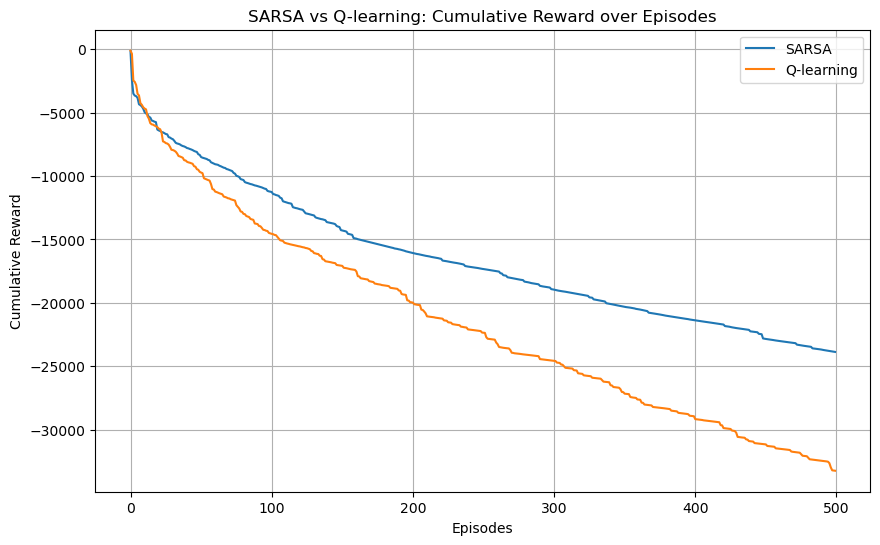

In [23]:
# 绘制学习曲线
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(sarsa_rewards), label='SARSA')
plt.plot(np.cumsum(q_learning_rewards), label='Q-learning')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('SARSA vs Q-learning: Cumulative Reward over Episodes')
plt.legend()
plt.grid(True)
plt.savefig('reward_comparison.png')
plt.show()
plt.close()



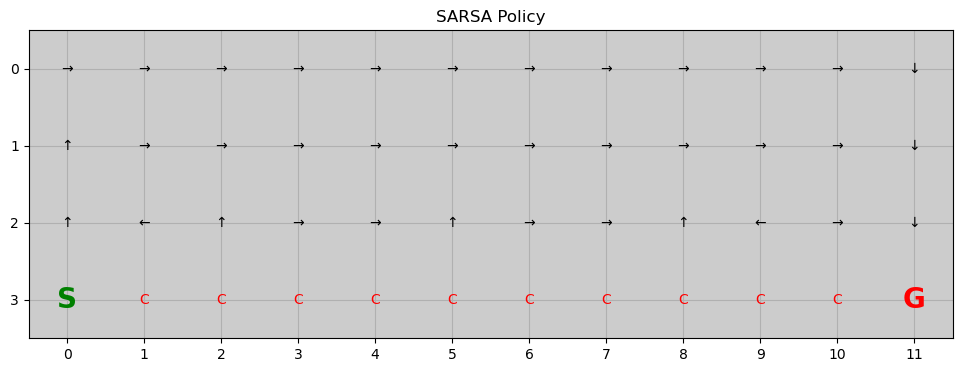

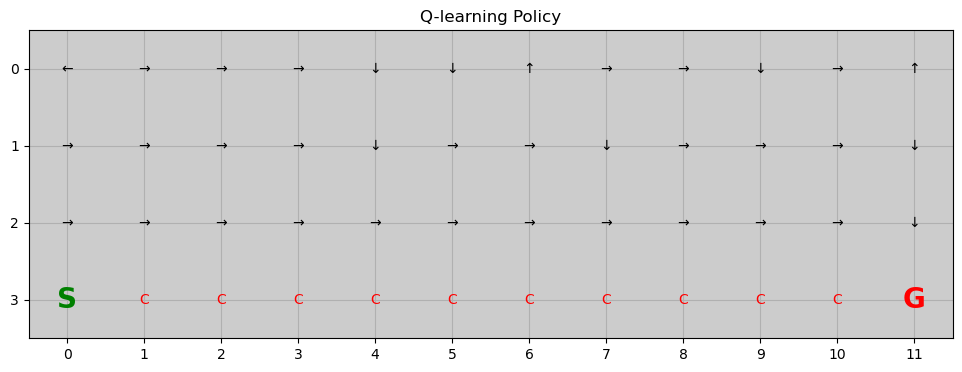

SARSA采取更安全的路线，远离悬崖。
Q-learning尝试走最短路径，更接近悬崖。


In [24]:
# 绘制SARSA的策略
plt_sarsa = plot_policy(sarsa_Q)
plt_sarsa.title('SARSA Policy')
plt_sarsa.savefig('sarsa_policy.png')
plt_sarsa.show()
plt_sarsa.close()

# 绘制Q-learning的策略
plt_q = plot_policy(q_learning_Q)
plt_q.title('Q-learning Policy')
plt_q.savefig('q_learning_policy.png')
plt_q.show()
plt_q.close()

print("SARSA采取更安全的路线，远离悬崖。")
print("Q-learning尝试走最短路径，更接近悬崖。")